# Importing packages

In [1]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [2]:
#from utils.model_summary_functions import metrics

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import warnings # Ignore alert messages
warnings.filterwarnings('ignore')

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 10),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


In [6]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback

# Importing reduced dataset with engineered features

In [7]:
# Dataset from the notebook "feature engineering"
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip")
y = pd.DataFrame(df['Vert_irreg_right_rail'])
X = df.drop(['Vert_irreg_right_rail'], axis=1)

In [8]:
X

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_y,Triaxial_z,Lead_z_accel_right_side,Susp_travel_left,Susp_travel_right,...,Pitch_right_susp_mean_55 samples,Pitch_left_susp_mean_55 samples,Pitch_left_susp_skew_55 samples,Bounce_susp_mean_55 samples,Bounce_susp_skew_55 samples,Back_Bounce_accel_mean_55 samples,Front_Roll_susp_skew_55 samples,Back_Roll_susp_mean_55 samples,Back_Roll_susp_skew_55 samples,Roll_susp_skew_55 samples
0,-0.022000,0.019500,0.014100,-0.014100,-0.000088,-0.000214,-0.000327,-0.000721,0.019500,-0.022000,...,0.000573,0.000611,0.172466,0.000959,-0.970640,0.001645,0.952321,0.010817,1.088276,1.032338
1,-0.022700,0.019800,0.014700,-0.014800,-0.000097,-0.000089,-0.000291,-0.000519,0.019800,-0.022700,...,0.000600,0.000629,0.117390,0.000889,-0.989087,0.001645,0.916181,0.011491,1.058112,1.007508
2,-0.022900,0.019400,0.015100,-0.015400,-0.000110,0.000067,-0.000261,-0.000150,0.019400,-0.022900,...,0.000625,0.000644,0.076343,0.000820,-0.975522,0.001645,0.870572,0.012173,1.015830,0.970558
3,-0.023100,0.019100,0.015600,-0.016000,-0.000124,0.000223,-0.000230,0.000219,0.019100,-0.023100,...,0.000649,0.000655,0.054845,0.000755,-0.943731,0.001645,0.819152,0.012863,0.966508,0.926259
4,-0.023200,0.018800,0.016000,-0.016600,-0.000137,0.000379,-0.000200,0.000588,0.018800,-0.023200,...,0.000670,0.000663,0.051975,0.000694,-0.902898,0.001645,0.764196,0.013557,0.911439,0.875788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201097,-0.208302,-0.125610,0.075205,0.084581,0.001973,-0.032745,0.000166,0.004698,-0.125610,-0.208302,...,0.030316,-0.049634,-0.139080,-0.142103,-1.118679,-0.015839,-0.780615,-0.664392,-0.791423,-0.563117
201098,-0.208775,-0.120864,0.082358,0.076294,0.001977,-0.031654,-0.000265,0.002599,-0.120864,-0.208775,...,0.032425,-0.049130,-0.173612,-0.136100,-1.154045,-0.015416,-0.798775,-0.606615,-0.823100,-0.531515
201099,-0.208950,-0.116413,0.090245,0.068181,0.001979,-0.030591,-0.000658,0.000248,-0.116413,-0.208950,...,0.034452,-0.048646,-0.207113,-0.130272,-1.179721,-0.014895,-0.817146,-0.550955,-0.855484,-0.501652
201100,-0.208970,-0.112264,0.098501,0.060593,0.001973,-0.029595,-0.000988,-0.001389,-0.112264,-0.208970,...,0.036399,-0.048197,-0.245583,-0.124647,-1.194865,-0.014364,-0.836259,-0.497343,-0.888273,-0.473939


In [9]:
X = X = X[1101:-1]
y = y.iloc[X.index]

In [10]:
X


,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_y,Triaxial_z,Lead_z_accel_right_side,Susp_travel_left,Susp_travel_right,...,Pitch_right_susp_mean_55 samples,Pitch_left_susp_mean_55 samples,Pitch_left_susp_skew_55 samples,Bounce_susp_mean_55 samples,Bounce_susp_skew_55 samples,Back_Bounce_accel_mean_55 samples,Front_Roll_susp_skew_55 samples,Back_Roll_susp_mean_55 samples,Back_Roll_susp_skew_55 samples,Roll_susp_skew_55 samples
1101,-4.480881,4.000728,6.637523,-6.788145,-0.050823,-0.026887,-0.216270,-0.205860,6.637523,-6.788145,...,0.102324,0.339877,-0.099058,-0.999687,1.682690,0.025072,-0.096954,1.235188,0.070434,-0.036791
1102,-4.360801,3.935177,6.630654,-6.576663,-0.058138,-0.056441,-0.191270,-0.257620,6.630654,-6.576663,...,0.085728,0.319752,-0.047396,-0.990023,1.679195,0.018725,-0.149450,1.592560,0.010995,-0.098414
1103,-4.229952,3.878878,6.611232,-6.342195,-0.063317,-0.078274,-0.172003,-0.363340,6.611232,-6.342195,...,0.068683,0.298310,0.009170,-0.977127,1.675218,0.012506,-0.202271,1.946340,-0.048682,-0.160499
1104,-4.094593,3.833739,6.577506,-6.089304,-0.068970,-0.093613,-0.154655,-0.296390,6.577506,-6.089304,...,0.051304,0.275658,0.070066,-0.917802,1.549711,0.007750,-0.255173,2.295913,-0.108556,-0.223068
1105,-3.954784,3.803312,6.527474,-5.829702,-0.075874,-0.102244,-0.133247,-0.370070,6.527474,-5.829702,...,0.033680,0.251939,0.134765,-0.856353,1.433871,0.002028,-0.307906,2.640618,-0.168588,-0.286140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201096,-0.207537,-0.130641,0.068856,0.093056,0.001956,-0.033871,0.000727,0.005745,-0.130641,-0.207537,...,0.028128,-0.050148,-0.100384,-0.148268,-1.075486,-0.016164,-0.762267,-0.724336,-0.760527,-0.596183
201097,-0.208302,-0.125610,0.075205,0.084581,0.001973,-0.032745,0.000166,0.004698,-0.125610,-0.208302,...,0.030316,-0.049634,-0.139080,-0.142103,-1.118679,-0.015839,-0.780615,-0.664392,-0.791423,-0.563117
201098,-0.208775,-0.120864,0.082358,0.076294,0.001977,-0.031654,-0.000265,0.002599,-0.120864,-0.208775,...,0.032425,-0.049130,-0.173612,-0.136100,-1.154045,-0.015416,-0.798775,-0.606615,-0.823100,-0.531515
201099,-0.208950,-0.116413,0.090245,0.068181,0.001979,-0.030591,-0.000658,0.000248,-0.116413,-0.208950,...,0.034452,-0.048646,-0.207113,-0.130272,-1.179721,-0.014895,-0.817146,-0.550955,-0.855484,-0.501652


## Preprocessing

In [11]:
def reshape_dataset(X, y,n=100):

    # [n_sampes,n_time_steps,input_dimension]
    shape_x = (-1, n, X.shape[1])
    shape_y = (-1, n, y.shape[1])

    X_reshaped = tf.reshape(X, shape=shape_x)
    y_reshaped = tf.reshape(y, shape=shape_y)
    return X_reshaped, y_reshaped

In [12]:
def create_scaled_dataset(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_scaled_dataset(X, y)

In [13]:
X.shape[0]*0.85

170000.0

In [14]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    ax.plot(model.history['loss'], label='Train Loss')
    ax.plot(model.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()

In [15]:
def create_scaled_dataset_reshaped(X,y,window_size=100):

    X_train, X_test, y_train, y_test = create_scaled_dataset(X, y)

    X_train_reshaped, y_train_reshaped = reshape_dataset(X_train, y_train, n=window_size)
    X_test_reshaped, y_test_reshaped = reshape_dataset(X_test, y_test, n=window_size)

    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

X_train_re,y_train_re,X_test_re,y_test_re = create_scaled_dataset_reshaped(X,y)

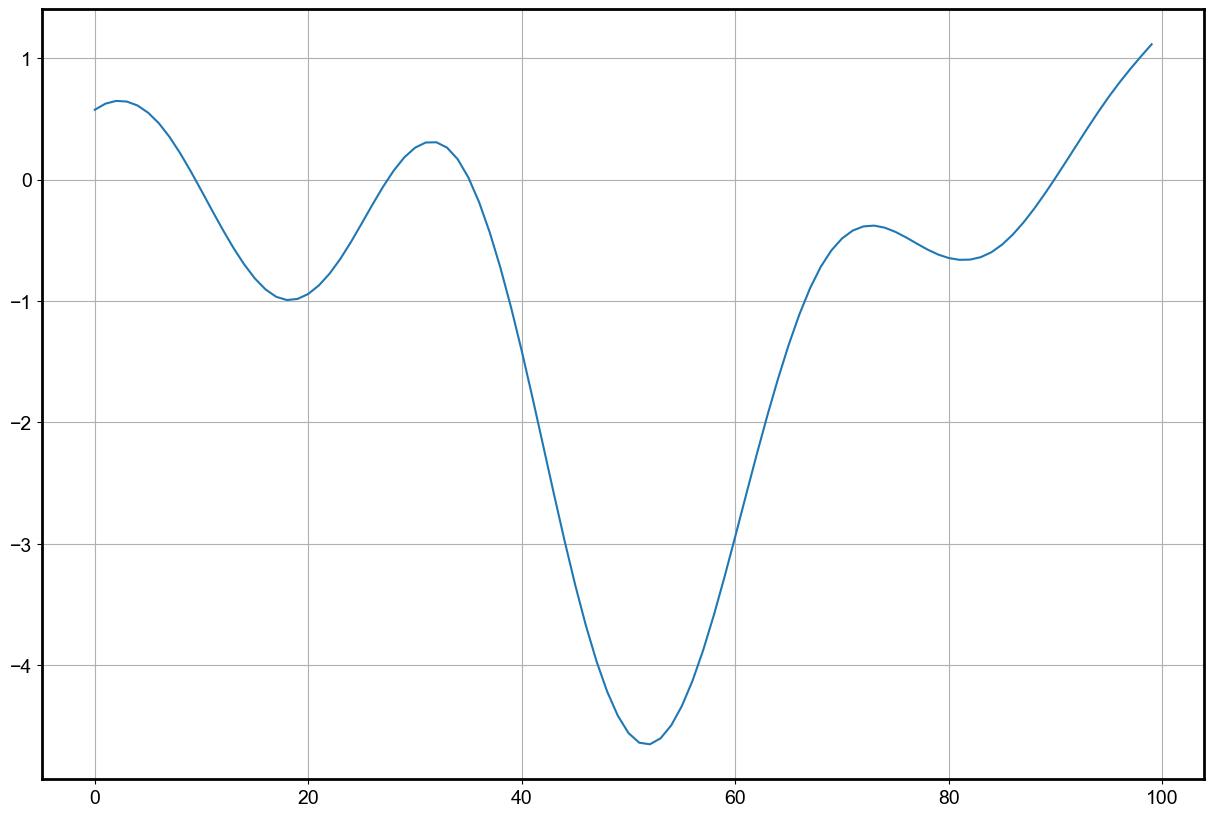

In [16]:
plt.plot(y_train_re[0])

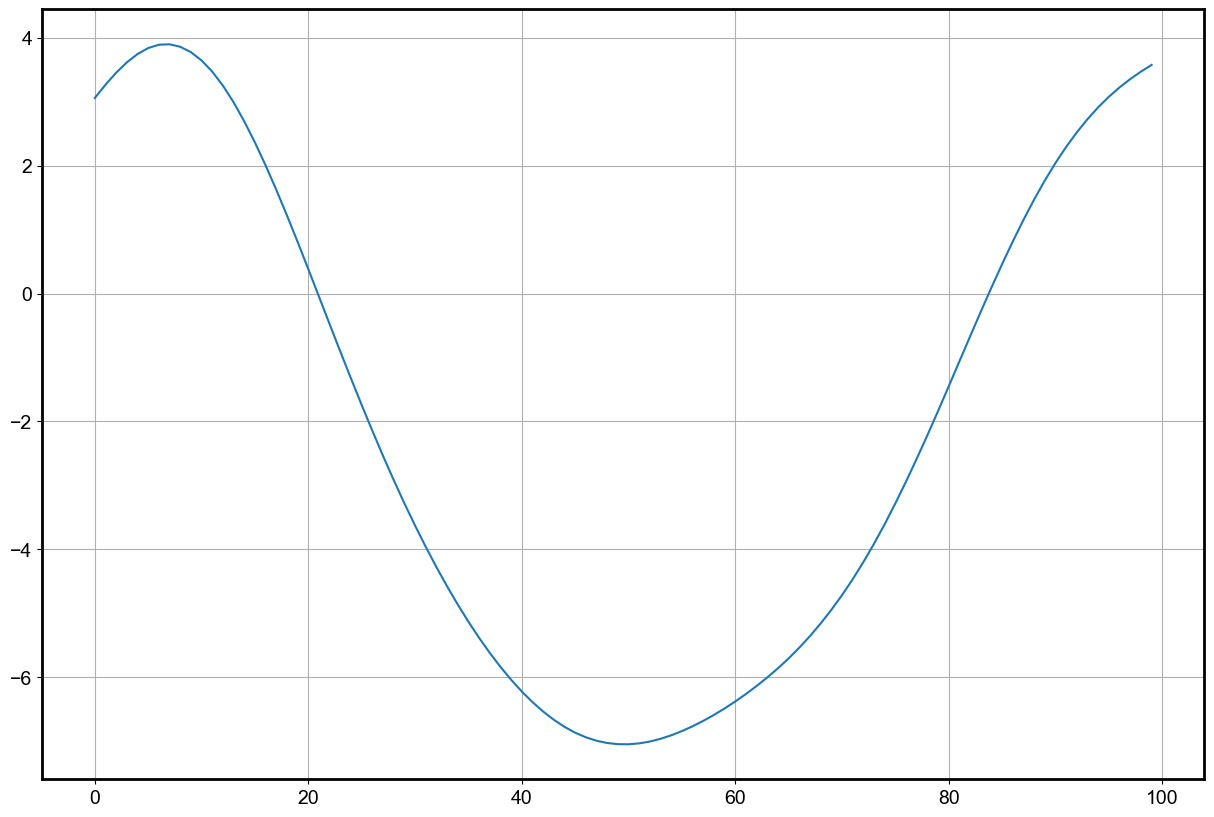

In [17]:
plt.plot(y_train_re[20])

In [18]:
X_train_re

<tf.Tensor: shape=(1700, 100, 50), dtype=float64, numpy=
array([[[-4.48088100e+00,  4.00072800e+00,  6.63752300e+00, ...,
          1.23518836e+00,  7.04343721e-02, -3.67911481e-02],
        [-4.36080100e+00,  3.93517700e+00,  6.63065400e+00, ...,
          1.59256045e+00,  1.09954460e-02, -9.84143846e-02],
        [-4.22995200e+00,  3.87887800e+00,  6.61123200e+00, ...,
          1.94634027e+00, -4.86824294e-02, -1.60499248e-01],
        ...,
        [ 2.50736600e+00, -2.32677100e+00, -4.50972600e+00, ...,
         -2.90301502e+00,  3.98784159e-02,  8.51014080e-02],
        [ 2.56845200e+00, -2.36155800e+00, -4.44510700e+00, ...,
         -3.04723873e+00,  9.29357800e-02,  1.32052929e-01],
        [ 2.62445600e+00, -2.40589300e+00, -4.37367900e+00, ...,
         -3.19185311e+00,  1.46370891e-01,  1.78637498e-01]],

       [[ 2.67498700e+00, -2.46339900e+00, -4.31301600e+00, ...,
         -3.33711002e+00,  1.99332403e-01,  2.23485433e-01],
        [ 2.73056400e+00, -2.53875100e+00, -4.

# LSTM


Order matters in a convolutional time series, therefore, we will need to recreate the dataset and **not** shuffle it

In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv1D, Reshape, Flatten, Conv1DTranspose, Concatenate, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam

## Optuna

In [20]:

class optuna_LSTM:
    
    def __init__(self,X,y):

        self.X = X
        self.y = y

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None


        self.best_model = None
        self._model = None
    
        
        self.callbacks = None
        self.history = None
        self._history = None
        
        self.batchsize = X_train.shape[0]

    def objective(self,trial):
        
        MAX_EPOCHS = 500
        PATIENCE = 12  # Number of epochs to check if the error continues to decrease
        INTERVAL = 150  # Intermediate results saved and pruned/removed if it is bad
        
        window_size = 250 #trial.suggest_categorical('window_size', [50, 70, 100, 125, 200, 250, 300,350500] ) 
        self.X_train, self.y_train, self.X_test, self.y_test = create_scaled_dataset_reshaped(self.X, self.y, window_size=window_size)
        
        tf.keras.backend.clear_session()

        # 1. Initializing number of layers

        num_layers = trial.suggest_int('n_layers', 1, 3)

        # 2. Initializing the model
        model = tf.keras.Sequential()

        for i in range(num_layers):
            LSTM_size = trial.suggest_int('LSTM_size_{}'.format(i), 100, 600, step=10)
            dropout_size = trial.suggest_float('dropout_val_{}'.format(i), 0, 0.5, step=0.05)

            model.add(LSTM(LSTM_size,return_sequences=True))
            model.add(Dropout(dropout_size))

        model.add(tf.keras.layers.Dense(self.y_train.shape[1], activation='linear'))

        # 4. Defining callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      mode='min')
    
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping,optuna_pruner]
        
        # 5. Compile and fit the model
        learning_rate =  trial.suggest_loguniform("lr", 1e-5, 1e-3)
        model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.X_train,
              self.y_train,
              epochs=MAX_EPOCHS,
              validation_split=0.15,
              callbacks=self.callbacks,
              #batch_size=self.batchsize,
              shuffle=True,
              verbose=0)   
        
        self._model = model
        
        MSE_score_test_set = model.evaluate(self.X_test, self.y_test, verbose=0)
        return MSE_score_test_set 
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history


In [21]:
opt_LSTM = optuna_LSTM(X, y)

In [22]:
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense

# X_train, y_train, X_test, y_test = create_scaled_dataset_reshaped(X, y, window_size=100)

# # define model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1:])))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# # fit model
# model.fit(X_train, y_train, epochs=200, verbose=0)

In [23]:
study3 = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=10),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name='LSTM')

[I 2021-08-10 14:10:06,671] A new study created in memory with name: LSTM


In [24]:
study3.optimize(opt_LSTM.objective,
               n_trials=100,
               callbacks=[opt_LSTM.callback],
               show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]


[W 2021-08-10 14:10:07,005] Trial 0 failed because of the following error: InvalidArgumentError()
Traceback (most recent call last):
  File "C:\Users\arthu\anaconda3\envs\LSTM\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\arthu\AppData\Local\Temp/ipykernel_14568/1796785936.py", line 32, in objective
    self.X_train, self.y_train, self.X_test, self.y_test = create_scaled_dataset_reshaped(self.X, self.y, window_size=window_size)
  File "C:\Users\arthu\AppData\Local\Temp/ipykernel_14568/3928853323.py", line 5, in create_scaled_dataset_reshaped
    X_train_reshaped, y_train_reshaped = reshape_dataset(X_train, y_train, n=window_size)
  File "C:\Users\arthu\AppData\Local\Temp/ipykernel_14568/3212823522.py", line 7, in reshape_dataset
    X_reshaped = tf.reshape(X, shape=shape_x)
  File "C:\Users\arthu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py", line 206, in wrapper
    return ta

InvalidArgumentError: Input to reshape is a tensor with 8500000 values, but the requested shape requires a multiple of 15000 [Op:Reshape]

In [ ]:
best_model = opt_LSTM.best_model
best_model_history = opt_LSTM.history

In [ ]:
best_model.save('models/NN/LSTM_optimize_window250')
reconstructed_model = tf.keras.models.load_model("models/NN/LSTM_optimize_window250")

INFO:tensorflow:Assets written to: models/NN/LSTM_optimize_window200\assets


INFO:tensorflow:Assets written to: models/NN/LSTM_optimize_window200\assets


In [ ]:
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 350)          561400    
_________________________________________________________________
dropout (Dropout)            (None, 200, 350)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 400)          1201600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 400)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 290)          801560    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 290)          0         
_________________________________________________________________
dense (Dense)                (None, 200, 200)          5

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(reconstructed_model, to_file='Images/LSTM.png',show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Visualize statistics

In [ ]:
pruned_trials = study3.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study3.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study3.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print('')
print('Best value')
print(study3.best_value)
print('Best parameters')
print(study3.best_params)


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  2
  Number of complete trials:  48

Best value
4.5603814125061035
Best parameters
{'n_layers': 3, 'LSTM_size_0': 350, 'dropout_val_0': 0.0, 'LSTM_size_1': 400, 'dropout_val_1': 0.2, 'LSTM_size_2': 290, 'dropout_val_2': 0.4, 'lr': 0.00078847842126029}


In [ ]:
optuna.visualization.plot_optimization_history(study3)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [ ]:
optuna.visualization.plot_slice(study3)  # best plot


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## Model performance

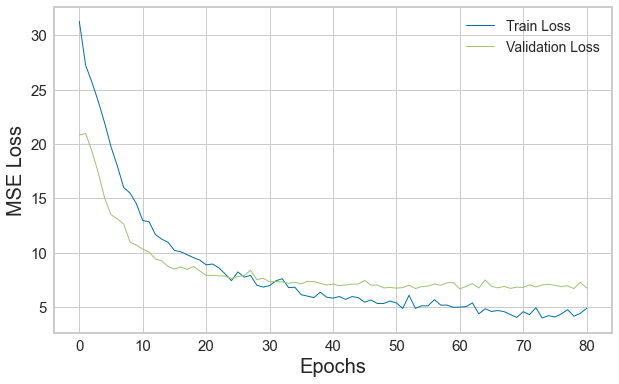

In [ ]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,6))
        
    ax.plot(model.history['loss'], label = 'Train Loss')
    ax.plot(model.history['val_loss'], label = 'Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()
    
plot_learning_curve(best_model_history)

In [ ]:
X_train_re, y_train_re, X_test_re, y_test_re = create_scaled_dataset_reshaped(X, y,window_size=80)

In [ ]:
reconstructed_model.evaluate(X_test_re,y_test_re)

3/3 [==============================] - 0s 5ms/step - loss: 5.6063


5.606282711029053

In [ ]:
yhat = reconstructed_model.predict(X_test_re)
yhat = yhat.reshape(-1, 1)
yhat.shape

(7200, 1)

In [ ]:
y_test_2 = tf.reshape(y_test_re, (y_test_re.shape[0]*y_test_re.shape[1],1))
y_test_2.shape

TensorShape([7200, 1])

(40440.05, 48358.95)

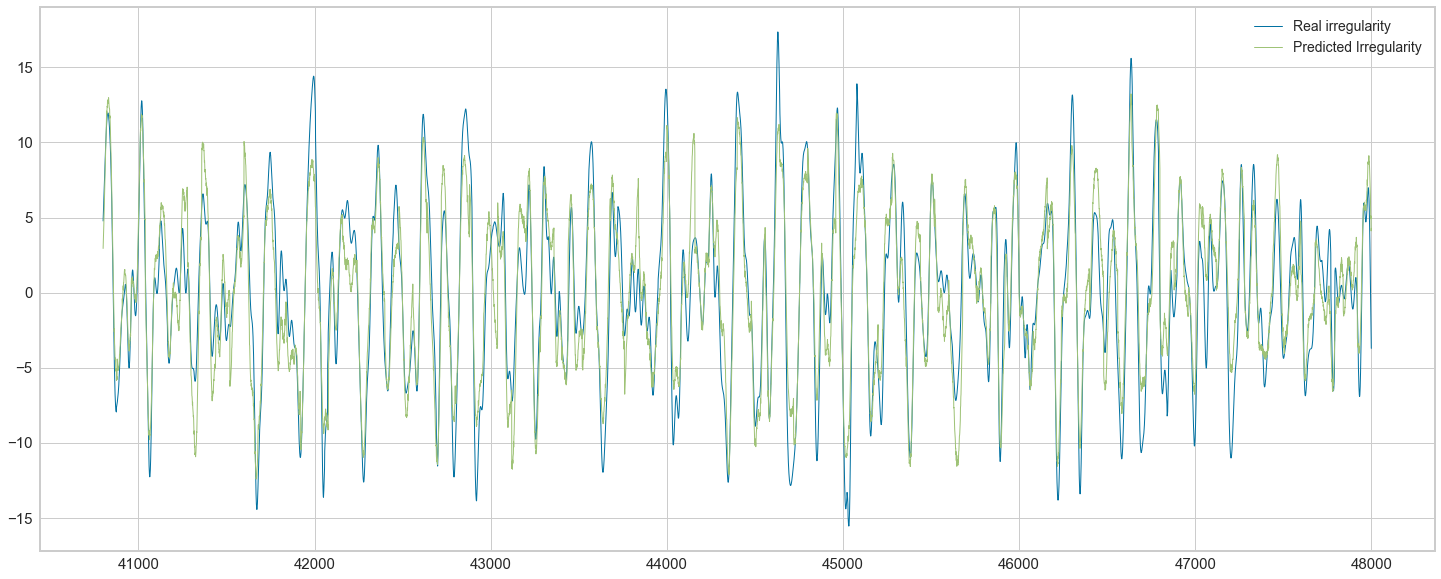

In [ ]:
plt.plot(y_test.index,y_test_2, label='Real irregularity')
plt.plot(y_test.index, yhat, label='Predicted Irregularity')
plt.legend()

plt.xlim()

Text(0.5, 0, 'Distance (m)')

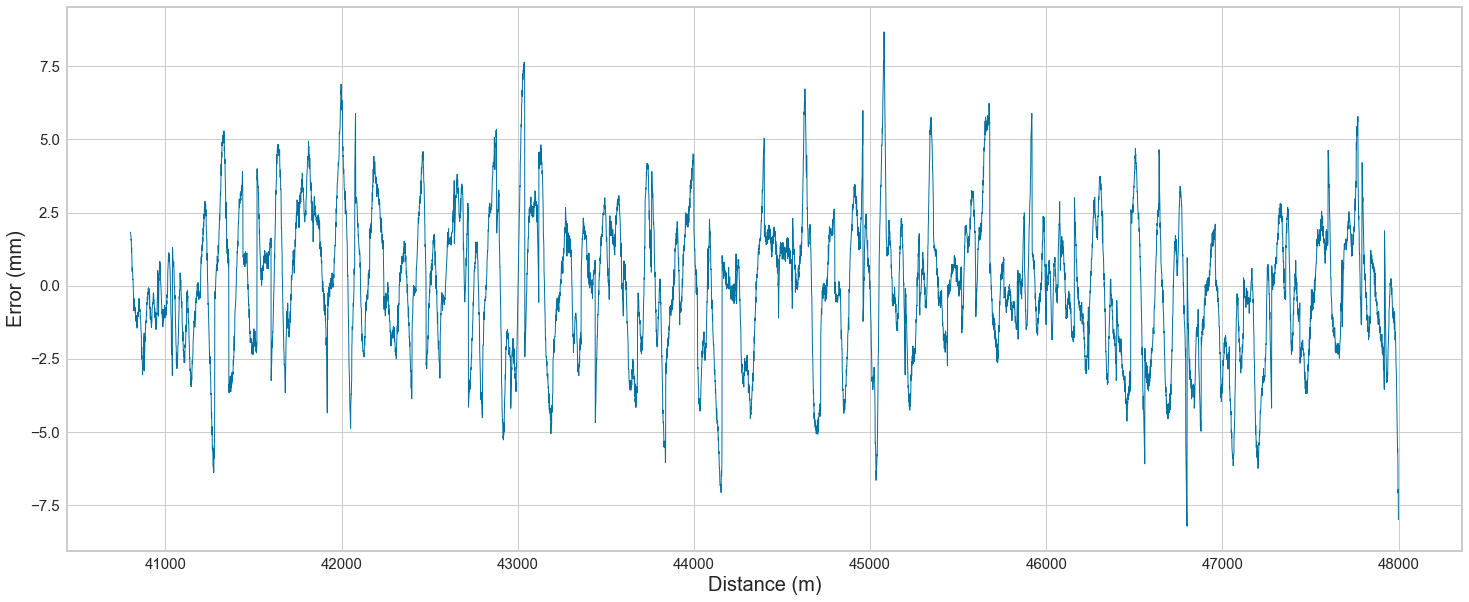

In [ ]:
error = y_test_2 - yhat
plt.plot(y_test.index,error)
plt.ylabel('Error (mm)')
plt.xlabel('Distance (m)')

In [ ]:
metrics(yhat,y_test_2)

MSE:5.606282598392154 
MAE:1.8803114802866308 
R2:0.7935696901959948
